## Sydney Basin Thunderstorm Climatology based on GPATS data

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

get_ipython().run_line_magic('matplotlib', 'inline')
# %matplotlib notebook for interactivity
import utility_functions_sep2018 as bous

'''
Just change station id variable to generate plots for other airports
'''

sta='YSSY' # change to explore fog plots for other locations
cur_dir='/home/accounts/qdisplay/avguide/app/data'

In [154]:
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
g_ms = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')
g_ms.tail()

,LATITUDE,LONGITUDE,AMP
TM,,,
2020-09-21 11:23:25.260,-34.00524,151.12358,-14.9
2020-09-21 11:24:23.725,-34.10694,151.11787,-27.5
2020-09-21 11:25:35.909,-34.10696,151.10039,-65.3
2020-09-21 11:25:35.953,-34.10568,151.06783,41.7
2020-09-21 11:28:29.815,-34.05155,151.14589,13.7


In [155]:
# daily gpats data counts
g_ms.resample('D')['AMP'].count().tail(10)

TM
2020-09-12     0
2020-09-13     0
2020-09-14     0
2020-09-15     0
2020-09-16     0
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    26
Freq: D, Name: AMP, dtype: int64

In [156]:
# resample introduce ALL days regardless TS/gpats - we drop those days with no gpats
g_tmp = g_ms.resample('D')['AMP'].count()
g_ts_days = g_tmp.loc[g_tmp>2]
g_ts_days.tail(10)

TM
2020-04-30    10
2020-05-13    17
2020-05-21    27
2020-06-07     4
2020-06-21     3
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     4
2020-09-21    26
Name: AMP, dtype: int64

In [157]:
# Now we have all the dates when we had storms 
# we just group by month and count how many per month to get monthly summaries
g_month = g_ts_days.groupby(g_ts_days.index.month).count()
g_month

TM
1     44
2     40
3     41
4     30
5     15
6     18
7     14
8     13
9     17
10    35
11    44
12    45
Name: AMP, dtype: int64

In [158]:
# Normalise to average monthly thunder days (divide by num of years)
g_month/12

TM
1     3.666667
2     3.333333
3     3.416667
4     2.500000
5     1.250000
6     1.500000
7     1.166667
8     1.083333
9     1.416667
10    2.916667
11    3.666667
12    3.750000
Name: AMP, dtype: float64

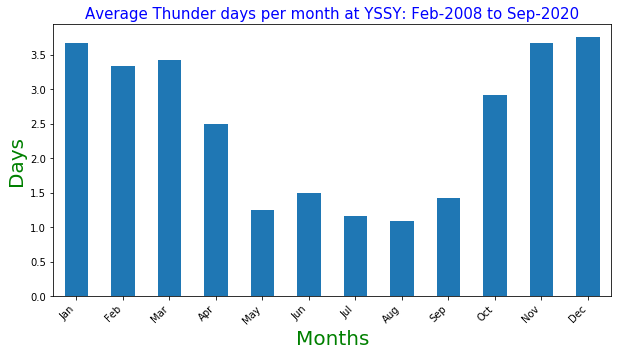

In [159]:
# see Fig 1.1 http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# that figure is 1939 to 2014 Average Thunder days per nonth
# trends are similar - peak about 3.5 days in Nov/Dec , so a TS every 3.5 days in Oct for e.g
# we have more broad peak Jan to Mar and Oct to Dec

dict_mon = dict(zip(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]))

dat = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').resample('D')['AMP'].count()
ts_days = dat.loc[dat>2]
avg_mon_ts_days = ts_days.groupby(ts_days.index.month).count()/12


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
avg_mon_ts_days.plot( kind='bar', ax=ax)
title = f'Average Thunder days per month at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Days', color='g', fontsize=20)
ax.set_xlabel('Months', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[dict_mon[x+1] for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [160]:
# Average thunder days annually  (bit more than what average annual thunder days map suggests)
sum(g_month/12)

29.666666666666668

![](tdays.png)

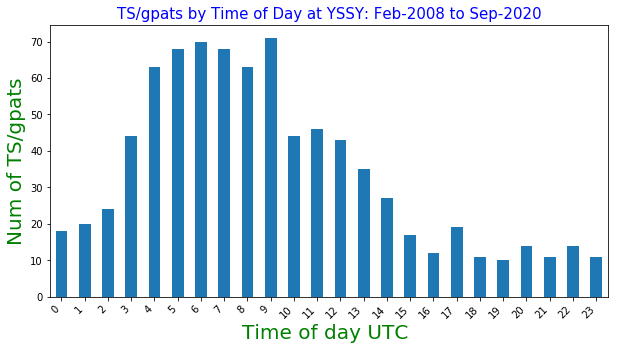

In [161]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()\
          .resample('H')['AMP'].count()
g1_hour = g1_hour.loc[g1_hour>1]
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
# gpats_by_hour/24


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'TS/gpats by Time of Day at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Num of TS/gpats', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [162]:
dict_mon
keys = list(dict_mon.keys())
vals = list(dict_mon.values())
print(keys[vals.index('Oct')])
print(keys[vals.index('Nov')])

10
11


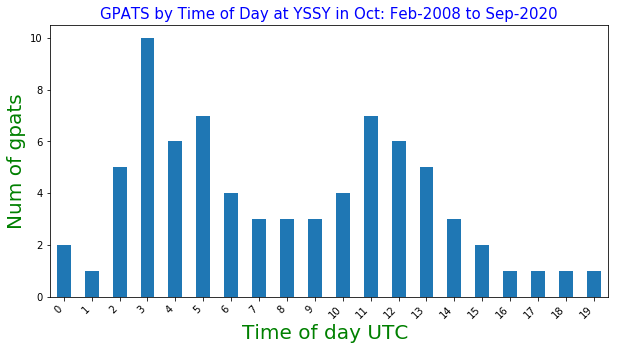

In [163]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()\
          .resample('H')['AMP'].count()

g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()

g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour

mon=keys[vals.index('Oct')]

g1_hour = g1_hour.loc[g1_hour.index.month==mon]  # hourly trend for October only
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
# gpats_by_hour/24


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'GPATS by Time of Day at {sta} in {dict_mon[mon]}: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Num of gpats', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [164]:
'''
resample data to 1min
 nb the counts would obviously be smaller given we not counting millisecond precision strikes
 good thing is we get max 1 gpats count for any minute , so its either 0 or 1
 giving max gpats count 60 in an hour, anythin in range 0 to 60
'''
g1_day = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
      .resample('1min')\
      .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
      .dropna()\
      .resample('D')['AMP'].count()
g1_day.tail()

TM
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    11
Freq: D, Name: AMP, dtype: int64

In [165]:
# drop days with no gpats
g1_day = g1_day.loc[g1_day>2]
g1_day.tail(10)

TM
2020-04-30     5
2020-05-13    13
2020-05-21    24
2020-06-07     4
2020-06-21     3
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     3
2020-09-21    11
Name: AMP, dtype: int64

In [166]:
g1_month = g1_day.groupby(g1_day.index.month).count()
g1_month

TM
1     43
2     39
3     41
4     28
5     15
6     16
7     13
8     13
9     16
10    34
11    44
12    45
Name: AMP, dtype: int64

TM
1     3.583333
2     3.250000
3     3.416667
4     2.333333
5     1.250000
6     1.333333
7     1.083333
8     1.083333
9     1.333333
10    2.833333
11    3.666667
12    3.750000
Name: AMP, dtype: float64


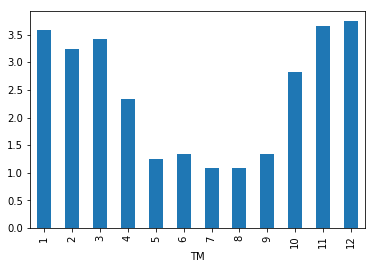

In [167]:
print((g1_month/12))
(g1_month/12).plot(kind='bar')

In [168]:
# note resample introduces hours in dataset even when no gpats
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').\
          resample('H')['AMP'].count()
g1_hour.tail()

TM
2020-09-21 07:00:00     0
2020-09-21 08:00:00     0
2020-09-21 09:00:00     0
2020-09-21 10:00:00     1
2020-09-21 11:00:00    25
Freq: H, Name: AMP, dtype: int64

In [169]:
# to check out any specific day - gpats count for each hour on that date
g1_hour.loc['29-03-2008']

TM
2008-03-29 00:00:00     0
2008-03-29 01:00:00     0
2008-03-29 02:00:00     0
2008-03-29 03:00:00     0
2008-03-29 04:00:00     0
2008-03-29 05:00:00     0
2008-03-29 06:00:00    14
2008-03-29 07:00:00     3
2008-03-29 08:00:00     0
2008-03-29 09:00:00     2
2008-03-29 10:00:00    19
2008-03-29 11:00:00    53
2008-03-29 12:00:00     7
2008-03-29 13:00:00     0
2008-03-29 14:00:00     3
2008-03-29 15:00:00     2
2008-03-29 16:00:00     0
2008-03-29 17:00:00     0
2008-03-29 18:00:00     0
2008-03-29 19:00:00     0
2008-03-29 20:00:00     0
2008-03-29 21:00:00     0
2008-03-29 22:00:00     0
2008-03-29 23:00:00     0
Freq: H, Name: AMP, dtype: int64

In [170]:
# drop hours when no gpats
g1_hour = g1_hour[g1_hour>0]
g1_hour.loc['29-03-2008']

TM
2008-03-29 06:00:00    14
2008-03-29 07:00:00     3
2008-03-29 09:00:00     2
2008-03-29 10:00:00    19
2008-03-29 11:00:00    53
2008-03-29 12:00:00     7
2008-03-29 14:00:00     3
2008-03-29 15:00:00     2
Name: AMP, dtype: int64

In [171]:
# get gpats count by hour for for each hour over all days/years
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
gpats_by_hour/24

TM
0     1.208333
1     1.250000
2     1.541667
3     2.458333
4     3.500000
5     3.750000
6     3.666667
7     3.500000
8     3.750000
9     3.875000
10    2.500000
11    2.583333
12    2.375000
13    1.875000
14    1.833333
15    1.166667
16    0.750000
17    1.125000
18    0.916667
19    0.791667
20    0.916667
21    0.625000
22    0.875000
23    0.833333
Name: AMP, dtype: float64

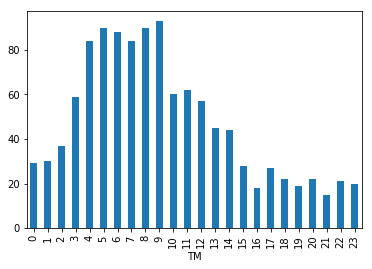

In [172]:
# see also fig 1.2  http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# very similar trends to whats here
g1_hour.groupby(g1_hour.index.hour).count().plot(kind='bar')

GPATS data from 2008-02-26 06:00:00 to 2020-09-21 11:00:00


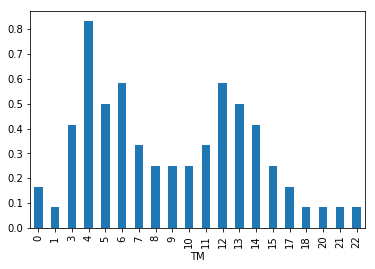

In [173]:
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()

g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour


print(f'GPATS data from {g1_hour.index[0]} to {g1_hour.index[-1]}')


# Filter for October storms hourly trend
mon=keys[vals.index('Oct')]
g1_oct = g1_hour.loc[g1_hour.index.month==mon]  # hourly trend for October only


gpats_by_hour = g1_oct.groupby(g1_oct.index.hour).count()


# normalise for 12 years

(g1_oct.groupby(g1_oct.index.hour).count()/12).plot(kind='bar')

For month of October, on average 
- storms observed about 6 days in Oct hours 3-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 3 to 7Z

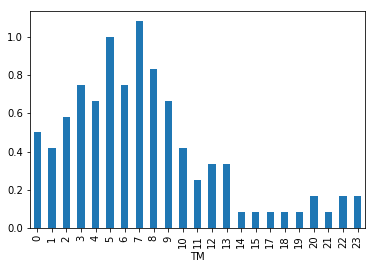

In [175]:
# November hourly trend 
mon=keys[vals.index('Dec')]
g1_dec = g1_hour.loc[g1_hour.index.month==mon]
(g1_dec.groupby(g1_dec.index.hour).count()/12).plot(kind='bar')

For month of November, on average 
- storms observed about 7 days in Oct hours 2-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 4 to 7Z , about 15 to 18 days have storms on average between these hours in Nov!

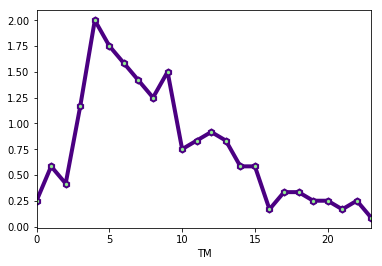

In [176]:
spring = (g1_hour.index.month == 9) | (g1_hour.index.month == 10) | (g1_hour.index.month == 11)
g1_spring = g1_hour.loc[spring]
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='#4b0082', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

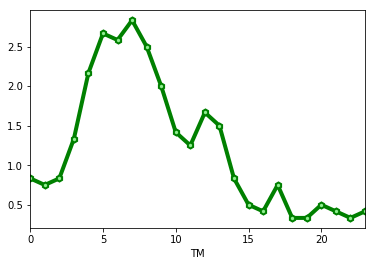

In [177]:
summer = (g1_hour.index.month == 12) | (g1_hour.index.month == 1) | (g1_hour.index.month == 2)
g1_summer = g1_hour.loc[summer]
(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='green', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

Text(0.5, 0, 'Time of day UTC ')

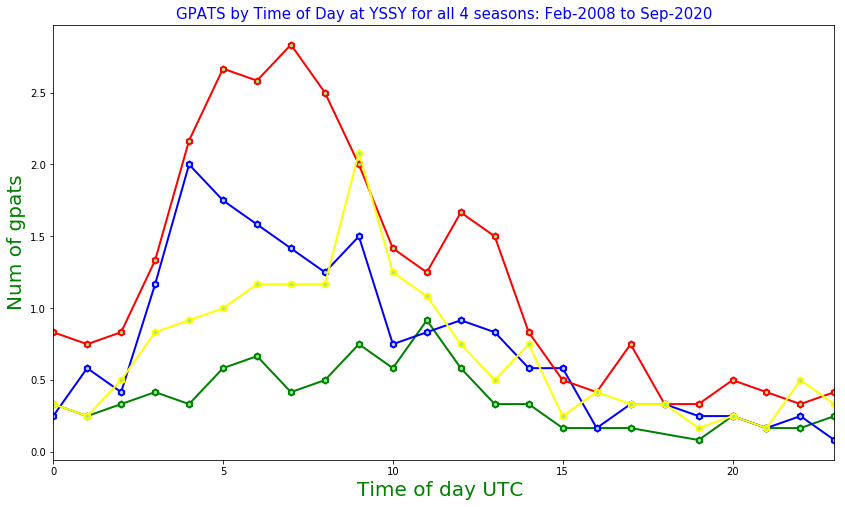

In [178]:
autumn = (g1_hour.index.month == 3) | (g1_hour.index.month == 4) | (g1_hour.index.month == 5)
g1_autumn = g1_hour.loc[autumn]
winter = (g1_hour.index.month == 6) | (g1_hour.index.month == 7) | (g1_hour.index.month == 8)
g1_winter = g1_hour.loc[winter]

fig, ax = plt.subplots(figsize=(14,8), nrows=1, ncols=1 )

(g1_winter.groupby(g1_winter.index.hour).count()/12).plot(kind='line', color='green', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='blue', linewidth=2,
         marker='h', markerfacecolor='lightblue', markeredgewidth=2)
(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='red', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)
(g1_autumn.groupby(g1_autumn.index.hour).count()/12).plot(kind='line', color='yellow', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

title = f'GPATS by Time of Day at {sta} for all 4 seasons: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Num of gpats', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)

Get relative frequeccies
How often SYd gets storms given there are storms at YSRI
COnditional probabilities

Storms YSSY given TS at YSRI
- P(TS YSSY | TS YSRI)
- P(TS YSSY | TS YSCN)

storms at Banks and Holls given TS Camden

- P(TS YSBK | TS YSCN)  or 
- P(TS YSHW | TS YSCN)


Load gpats - get TS dates and set arithmatic to get conditionals